In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Tess Dataset - https://www.kaggle.com/ejlok1/toronto-emotional-speech-set-tess

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy
import scipy.signal as sig
import librosa
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam

# **Utility Functions**

### **Function to remove Noise using IIR Filter**
* Electrical interference from power lines or electronics can produce a buzzy noise with a frequency content around 50-60 Hz or its harmonics.

In [ ]:
def removeNoise(data, fs) : 
  # Define filter parameters
  cutoff_freq = 150  # Hz
  filter_order = 6

  # Design low-pass filter
  b, a = sig.butter(filter_order, cutoff_freq/(fs/2), 'high')

  # Apply low-pass filter
  filtered_data = sig.filtfilt(b, a, data)

  low_cutoff = 5000
  b2, a2 = sig.butter(filter_order, low_cutoff/(fs/2), 'low')
  filtered = sig.filtfilt(b2, a2, filtered_data)

  return filtered

### **Read an audio file**



In [ ]:
def readAudioData(path):
  
  audio_file = path
  # sr - sampling rate
  audio, sr = librosa.load(audio_file, mono=True)
  audio = removeNoise(audio, sr);

  # Set window size and hop size
  win_size = int(0.025 * sr) # 25 ms window size
  hop_size = int(0.01 * sr) # 10 ms hop size

  # Compute the Short-Time Fourier Transform (STFT)
  f, t, Zxx = sig.stft(audio, fs=sr, window='hamming', nperseg=win_size, noverlap=win_size-hop_size)

  # Calculate the magnitude spectrum for each frame
  mag_spec = np.abs(Zxx)

  # Group the coefficients into sub-bands (e.g., 10 bands)
  n_bands = 10
  sub_bands = np.linspace(0, len(f), n_bands+1, dtype=int)

  # Calculate statistical features for each sub-band
  features = []
  for i in range(mag_spec.shape[1]):
      frame = mag_spec[:, i]
      band_features = []
      for j in range(len(sub_bands)-1):
          band = frame[sub_bands[j]:sub_bands[j+1]]
          band_mean = np.mean(band)
          band_std = np.std(band)
          band_skew = scipy.stats.skew(band)
          band_kurt = scipy.stats.kurtosis(band)
          band_features.append(band_mean)
          band_features.append(band_std)
          band_features.append(band_skew)
          band_features.append(band_kurt)
      features.append(band_features)

  # Convert the feature list to a numpy array
  features = np.array(features)
  
  # flattening the features to train the model
  features = features.flatten()

  return features

### **Read Full Directory**

In [ ]:
# Set directory path
def readFullDirectory(dir_path) :
  # Get list of all WAV files in directory
  files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]

  # Loop over WAV files and load audio data
  X = []
  for fil in files:
    filePath = os.path.join(dir_path, fil)
    features = readAudioData(filePath)
    X.append(features)
  
  # Find the maximum length of the inner lists
  max_len = max(map(len, X))

  # Pad the inner arrays with zeros
  X = np.array([np.pad(inner_array, (0, max_len - len(inner_array)), 'constant', constant_values=0) for inner_array in X])

  # Convert the modified list to a numpy array
  X = np.array(X)
  return X
  

### **Save as CSV**

In [ ]:

def saveCSV(array, path):
  
  df = pd.DataFrame(array)
  df.to_csv(path, index=False)

### **Normalisation of features**

In [ ]:
def normaliseFeatures(features) :
  
  # Create a MinMaxScaler object
  scaler = MinMaxScaler()

  # Normalize the data
  normalized_data = scaler.fit_transform(features)

  return normalized_data


# **Analysis**

### **Male Speeches**

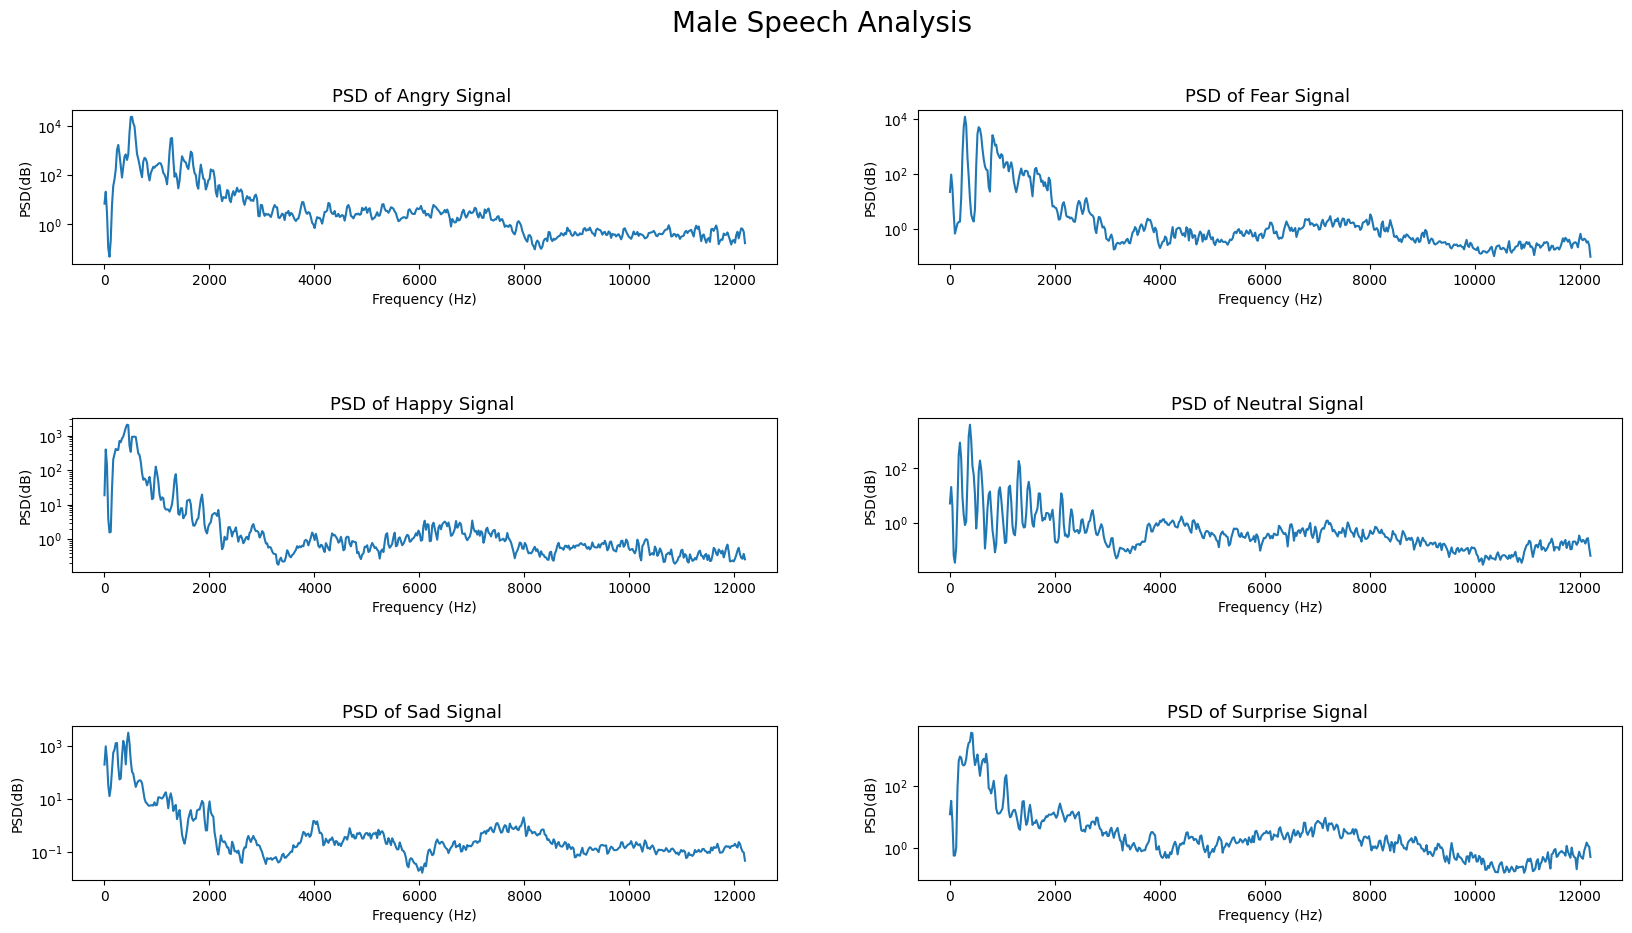

In [ ]:
dir_path = '/content/drive/MyDrive/Sem-6/dsp_project/emotions'
folder_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 10))

for i, folder in enumerate(folder_names):
  folder_path = os.path.join(dir_path, folder)

  # Get the list of files in the folder
  file_list = os.listdir(folder_path)

  # Get the path of the first audio file in the folder
  audio_file_path = os.path.join(folder_path, file_list[0])

  audio_sr, audio_data = wavfile.read(audio_file_path)

  # Calculate PSD using Welch's method
  frequencies, psd = sig.welch(audio_data, audio_sr, nperseg=1024)

  axs[i//2, i%2].semilogy(frequencies, psd)
  axs[i//2, i%2].set_xlabel('Frequency (Hz)')
  axs[i//2, i%2].set_ylabel('PSD(dB)')
  axs[i//2, i%2].set_title(f'PSD of {emotions[i]} Signal ', fontsize=13) 

fig.subplots_adjust(hspace=1)
plt.suptitle('Male Speech Analysis', fontsize = 20)
plt.show() 


### **Female Speeches**

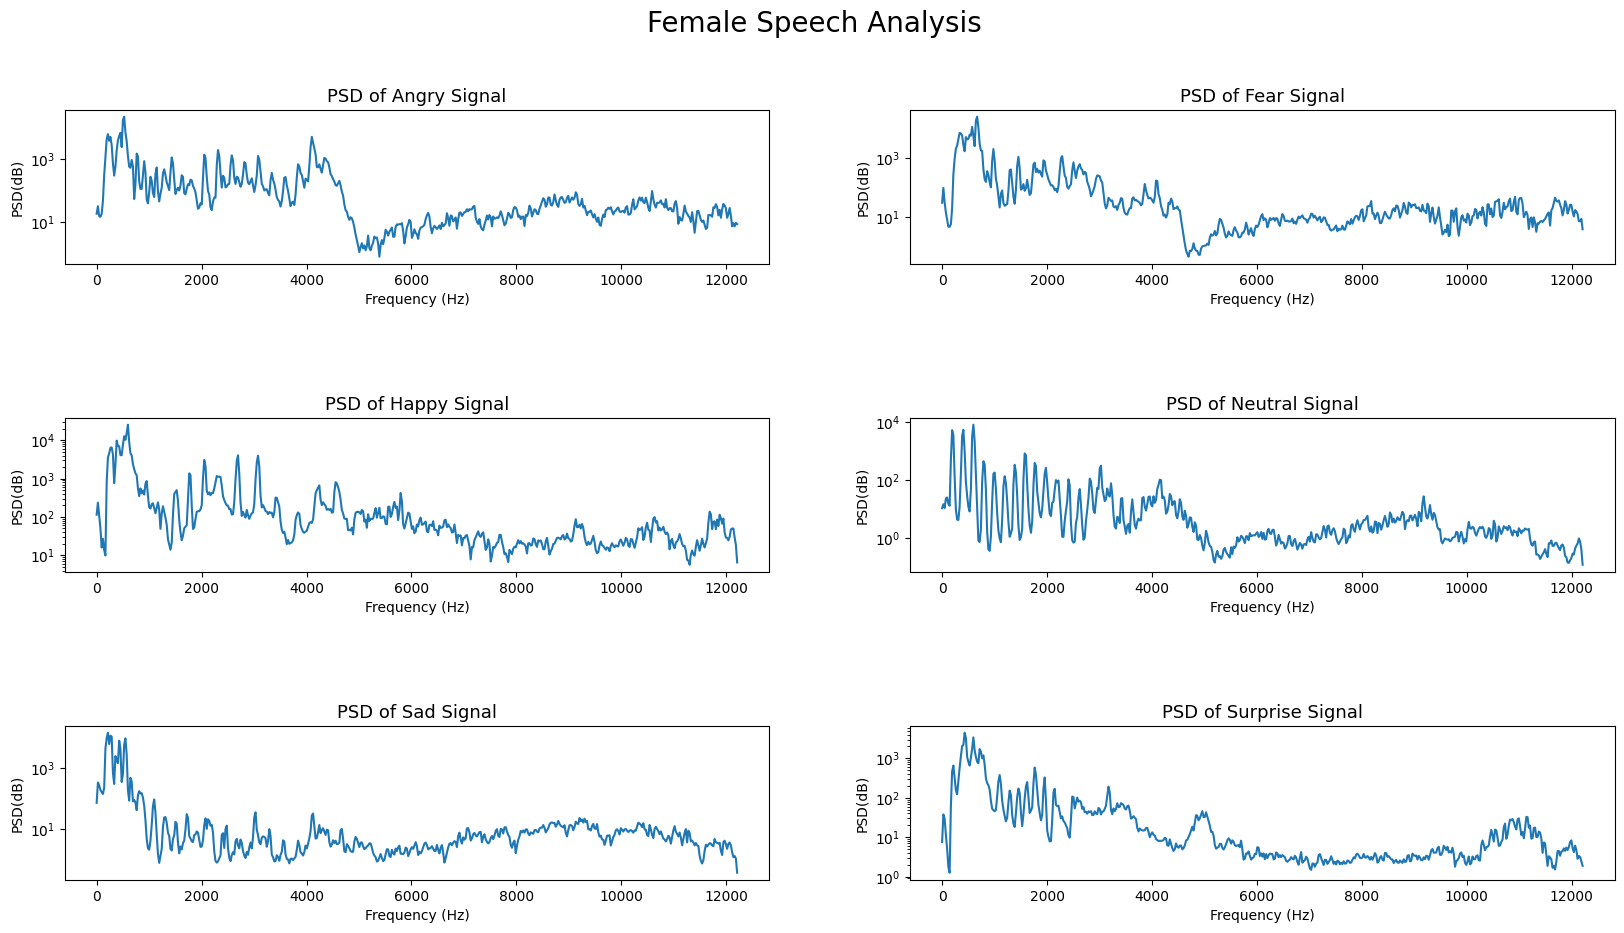

In [ ]:

female_audios = ['/content/drive/MyDrive/Sem-6/dsp_project/emotions/angry/YAF_bean_angry.wav',
                '/content/drive/MyDrive/Sem-6/dsp_project/emotions/fear/YAF_beg_fear.wav',
                '/content/drive/MyDrive/Sem-6/dsp_project/emotions/happy/YAF_chair_happy.wav',
                '/content/drive/MyDrive/Sem-6/dsp_project/emotions/neutral/YAF_lid_neutral.wav',
                '/content/drive/MyDrive/Sem-6/dsp_project/emotions/sad/YAF_door_sad.wav',
                '/content/drive/MyDrive/Sem-6/dsp_project/emotions/surprise/YAF_king_ps.wav'
                ]
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 10))

for i, audio_path in enumerate(female_audios):
  audio_sr, audio_data = wavfile.read(audio_path)
  
  frequencies, psd = sig.welch(audio_data, audio_sr, nperseg=1024)
  axs[i//2, i%2].semilogy(frequencies, psd)
  axs[i//2, i%2].set_xlabel('Frequency (Hz)')
  axs[i//2, i%2].set_ylabel('PSD(dB)')
  axs[i//2, i%2].set_title(f'PSD of {emotions[i]} Signal', fontsize=13)  

fig.subplots_adjust(hspace=1)
plt.suptitle('Female Speech Analysis', fontsize = 20)
plt.show()


## **Noise Removal Demonstration**

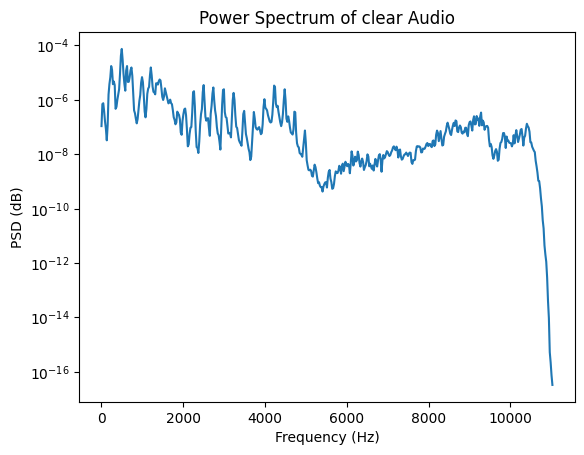

In [ ]:
femaleAngry = '/content/drive/MyDrive/Sem-6/dsp_project/emotions/angry/YAF_burn_angry.wav'
audio_data, audio_sr = librosa.load(femaleAngry, mono=True)

# Plot Power Spectrum of Clear Audio File
frequencies, psd = sig.welch(audio_data, audio_sr, nperseg=1024)
plt.semilogy(frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title('Power Spectrum of clear Audio')

# Play audio
Audio(data=audio_data, rate=audio_sr)

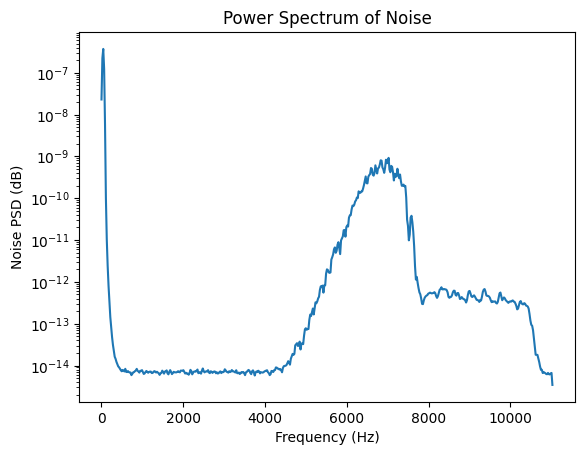

In [ ]:
noise_file = '/content/drive/MyDrive/Sem-6/dsp_project/noise.wav'
noise, noise_sr = librosa.load(noise_file, mono=True)

# Plot Power Spectrum of Noise
noise_freq, noise_psd = sig.welch(noise, noise_sr, nperseg=1024)
plt.semilogy(noise_freq, noise_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Noise PSD (dB)')
plt.title('Power Spectrum of Noise')

# Play Audio
Audio(data=noise, rate=noise_sr)

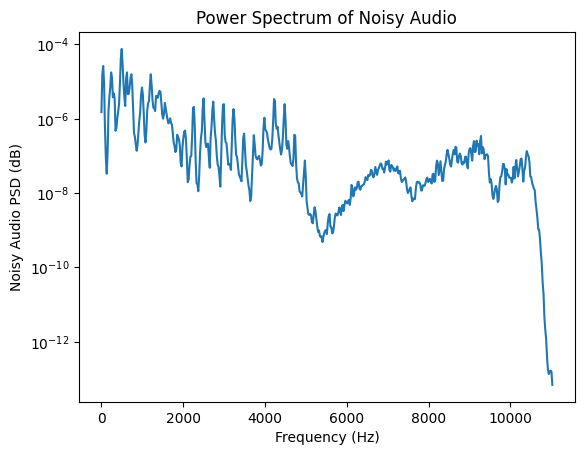

In [ ]:
noisy = audio_data + 5*noise[:audio_data.shape[0]]

noisy_audio_freq, noisy_audio_psd = sig.welch(noisy, noise_sr, nperseg=1024)
plt.semilogy(noisy_audio_freq, noisy_audio_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Noisy Audio PSD (dB)')
plt.title('Power Spectrum of Noisy Audio')

# Play Audio
Audio(data=noisy, rate=audio_sr)

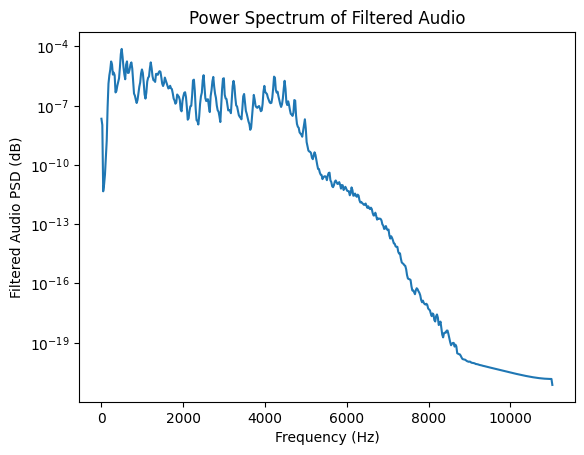

In [ ]:
filtered = removeNoise(noisy, audio_sr)

filtered_freq, filtered_psd = sig.welch(filtered, audio_sr, nperseg=1024)
plt.semilogy(filtered_freq, filtered_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filtered Audio PSD (dB)')
plt.title('Power Spectrum of Filtered Audio')

# Play Audio
Audio(data=filtered, rate=audio_sr)

In [ ]:
maleAngry = '/content/drive/MyDrive/Sem-6/dsp_project/emotions/angry/OAF_back_angry.wav'
male_audio, male_sr = librosa.load(maleAngry)

# Play audio
Audio(data=male_audio, rate=male_sr)

In [ ]:
male_filtered = removeNoise(male_audio, male_sr)
Audio(data=male_filtered, rate=male_sr)

# **Preprocessing**

In [ ]:
# Change the file paths as saved by you

data = [
    ('angry', '/content/drive/MyDrive/Sem-6/dsp_project/emotions/angry'),
    ('fear', '/content/drive/MyDrive/Sem-6/dsp_project/emotions/fear'),
    ('happy', '/content/drive/MyDrive/Sem-6/dsp_project/emotions/happy'),
    ('neutral', '/content/drive/MyDrive/Sem-6/dsp_project/emotions/neutral'),
    ('sad', '/content/drive/MyDrive/Sem-6/dsp_project/emotions/sad'),
    ('surprise', '/content/drive/MyDrive/Sem-6/dsp_project/emotions/surprise')
]

### **Loading and saving features as csv files**

In [ ]:
# Done
# for emotionData in data :
#   emotion, path = emotionData
#   features = readFullDirectory(path)
#   features = normaliseFeatures(features)
#   csvPath = '/content/drive/MyDrive/Sem-6/dsp_project/features/' + emotion + '.csv'
#   saveCSV(array=features, path=csvPath)

# **Features and Labels Engineering**

In [ ]:
featuresDir = "/content/drive/MyDrive/Sem-6/dsp_project/features/"
emotion_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotion_id = dict()

for i, emotion_name in enumerate(emotion_names) :
  emotion_id[emotion_name] = i

In [ ]:
featurePath = featuresDir + 'angry' + '.csv'
df = pd.read_csv(featurePath)
X = df.values.tolist()
y = [emotion_id['angry']] * len(X)

for emotion in emotion_names :
  if emotion == 'angry' : 
    continue;
  featurePath = featuresDir + emotion + '.csv'
  df = pd.read_csv(featurePath)
  xi = df.values.tolist()
  X += xi

  yi = [emotion_id[emotion]] * len(xi)
  y += yi

In [ ]:
for i in range(len(X)):
  X[i] = np.array(X[i])

max_len = max(map(len, X))

# Pad the inner arrays with zeros
X = np.array([np.pad(inner_array, (0, max_len - len(inner_array)), 'constant', constant_values=0) for inner_array in X])

# Convert the modified list to a numpy array
X = np.array(X)
y = np.array(y)

In [ ]:
# Randomisation of Features and Labels Arrays

idx = np.arange(X.shape[0])
np.random.shuffle(idx)

F, l = [], []

for i in idx :
  F.append(X[i])
  l.append(y[i])

F, l = np.array(F), np.array(l)
F = F[:, :8000]

# **Model**

In [ ]:
F.shape

(2406, 8000)

In [ ]:
l.shape

(2406,)

In [ ]:
# define the input shape
input_shape = (F.shape[1],)

# define the model architecture
model = keras.Sequential([
    Dense(16, activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(1.5)),
    Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1.5))
])

# compile the model
model.compile(optimizer=Adam(learning_rate=0.000005), loss='categorical_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 16)                128016    
                                                                 
 dense_25 (Dense)            (None, 6)                 102       
                                                                 
Total params: 128,118
Trainable params: 128,118
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Dont do like labels = keras.utils.to_categorical(labels, num_classes=6) --- labels array will change
features = F
labels = keras.utils.to_categorical(l, num_classes=6)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=5)

In [ ]:
X_train.shape

(1924, 8000)

In [ ]:
X_test.shape

(482, 8000)

In [ ]:
model.fit(X_train, y_train, validation_split=0.2, epochs=100)

Epoch 1/100
49/49 [==============================] - 0s 6ms/step - loss: 9.3211 - accuracy: 0.9981 - val_loss: 9.3245 - val_accuracy: 0.9974
Epoch 2/100
49/49 [==============================] - 0s 4ms/step - loss: 9.3096 - accuracy: 0.9981 - val_loss: 9.3119 - val_accuracy: 0.9974
Epoch 3/100
49/49 [==============================] - 0s 4ms/step - loss: 9.2969 - accuracy: 0.9981 - val_loss: 9.2999 - val_accuracy: 0.9974
Epoch 4/100
49/49 [==============================] - 0s 5ms/step - loss: 9.2855 - accuracy: 0.9981 - val_loss: 9.2883 - val_accuracy: 0.9974
Epoch 5/100
49/49 [==============================] - 0s 5ms/step - loss: 9.2738 - accuracy: 0.9974 - val_loss: 9.2759 - val_accuracy: 0.9974
Epoch 6/100
49/49 [==============================] - 0s 5ms/step - loss: 9.2607 - accuracy: 0.9981 - val_loss: 9.2646 - val_accuracy: 0.9974
Epoch 7/100
49/49 [==============================] - 0s 6ms/step - loss: 9.2489 - accuracy: 0.9981 - val_loss: 9.2510 - val_accuracy: 0.9974
Epoch 8/100
4

### **Evaluation on Test Set**

In [ ]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 3ms/step - loss: 8.1763 - accuracy: 0.9959


[8.176284790039062, 0.9958506226539612]

### **Testing on Test Set**

16/16 [==============================] - 0s 2ms/step


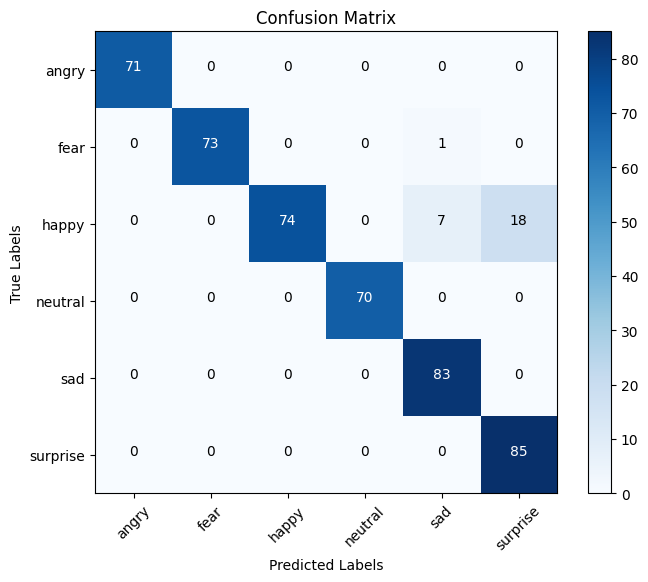

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy() 

y_true = tf.argmax(y_test, axis=1).numpy()  # Convert true labels to classes
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.colorbar()
tick_marks = np.arange(len(emotion_names))
plt.xticks(tick_marks, emotion_names, rotation=45)
plt.yticks(tick_marks, emotion_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
dim = X_test.shape[1]

for i in range(X_test.shape[0]) :
  feat, lab = X_test[i], y_test[i]
  prediction = model.predict(feat.reshape(-1, dim))
  p = np.argmax(prediction)
  c = np.argmax(lab)

  pred_emotion = emotion_names[p]
  correct_emotion = emotion_names[c]

  print(f'Correct - {correct_emotion} ------- Predicted - {pred_emotion}')

1/1 [==============================] - 0s 70ms/step
Correct - angry ------- Predicted - angry
1/1 [==============================] - 0s 30ms/step
Correct - sad ------- Predicted - sad
1/1 [==============================] - 0s 30ms/step
Correct - angry ------- Predicted - angry
1/1 [==============================] - 0s 28ms/step
Correct - angry ------- Predicted - angry
1/1 [==============================] - 0s 28ms/step
Correct - happy ------- Predicted - happy
1/1 [==============================] - 0s 29ms/step
Correct - fear ------- Predicted - fear
1/1 [==============================] - 0s 29ms/step
Correct - happy ------- Predicted - happy
1/1 [==============================] - 0s 36ms/step
Correct - fear ------- Predicted - fear
1/1 [==============================] - 0s 26ms/step
Correct - neutral ------- Predicted - neutral
1/1 [==============================] - 0s 27ms/step
Correct - fear ------- Predicted - fear
1/1 [==============================] - 0s 28ms/step
Correct - surp